In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('c:/Users/sabri/Downloads/GSAF5.xls')
#print(df.head())

In [3]:
print(df.columns)
print("\nDimensions of DataFrame :")
print(df.shape)
#print(df.dtypes)

Index(['Date', 'Year', 'Type', 'Country', 'State', 'Location', 'Activity',
       'Name', 'Sex', 'Age', 'Injury', 'Fatal Y/N', 'Time', 'Species ',
       'Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1',
       'original order', 'Unnamed: 21', 'Unnamed: 22'],
      dtype='object')

Dimensions of DataFrame :
(7012, 23)


In [4]:
missing_values = df.isnull().sum() # Check for missing values in the dataset
print("Missing values per column:")
print(missing_values[missing_values > 0])# Display columns with missing values

Missing values per column:
Year                 2
Type                18
Country             50
State              485
Location           566
Activity           585
Name               219
Sex                579
Age               2994
Injury              35
Fatal Y/N          561
Time              3526
Species           3131
Source              19
pdf                213
href formula       218
href               216
Case Number        214
Case Number.1      215
original order     213
Unnamed: 21       7011
Unnamed: 22       7010
dtype: int64


In [5]:
df_copy=df.copy()
df_copy.columns = df_copy.columns.str.strip()
# Drop unnecessary columns
df_copy.drop(columns=['Source', 'pdf', 'href formula', 'href', 'Case Number', 'Case Number.1', 'original order', 'Unnamed: 21', 'Unnamed: 22'],inplace=True,errors='ignore')

In [6]:
#clean and convert Date
def handle_invalid_dates_raw(value):
    if isinstance(value, str):  # Check if the value is a string
        if "Before" in value:  # Handle "Before" cases
            return '1902-12-31'  # Placeholder date
        elif "-" in value:  # Handle ranges like "1900-1905"
            return value.split('-')[0] + '-01-01'  # Start of the range
    return value  # Return as is for valid entries

#Apply the cleaning function to the original data before converting
df_copy['Date'] = df_copy['Date'].apply(handle_invalid_dates_raw)

# Convert to datetime after cleaning
df_copy['Date'] = pd.to_datetime(df_copy['Date'], errors='coerce')
df_copy = df_copy.dropna(subset=['Date'])
print(df_copy['Date'])

0      2025-04-19
1      2025-04-12
2      2025-03-26
3      2025-03-10
4      2025-03-07
          ...    
7007   1902-12-31
7008   1902-12-31
7009   1900-01-01
7010   1883-01-01
7011   1845-01-01
Name: Date, Length: 6215, dtype: datetime64[ns]


In [7]:
#clean and convert Year

df_copy['Extracted_Year'] = df_copy['Date'].dt.year# Extract the year from the "Date" column
df_copy['Year'] = df_copy['Extracted_Year']# Replace invalid years in "Year" with the extracted year
df_copy = df_copy.drop(columns=['Extracted_Year'])# Drop the temporary column
df_copy = df_copy.dropna(subset=['Year'])# Drop Rows with NaT
df_copy['Year'] = df_copy['Year'].astype(int)

In [8]:
#clean and convert Time
df_copy['Time'] = df_copy['Time'].str.lower().str.strip().replace({
    'early morning': '06:00', 'morning': '09:00', 'midday': '12:00',
    'afternoon': '15:00', 'late afternoon': '16:30', 'evening': '19:00',
    'night': '21:00', 'midnight': '00:00', 'dawn': '05:00', 'sunset': '18:30', 
    'lunchtime': '12:30', 'just before noon': '11:50'
    
}) # Replaces descriptive time values with standard HH:MM format.

df_copy['Time'] = df_copy['Time'].str.extract(r'(\d{1,2}[h:]?\d{0,2})') # Captures numeric time formats like "14h30", "14:30", or "1430".
df_copy['Time'] = df_copy['Time'].str.replace('h', ':').str.replace('"', '').str.strip()# Standardize separators ('h' → ':'), remove quotes, and strip spaces
df_copy['Time'] = df_copy['Time'].str.replace(r'(\d{2})(\d{2})', r'\1:\2', regex=True) # Inserts a colon (:) between hours and minutes, e.g., "1430" → "14:30"

#How Regex Works Here
#Pattern Explanation (r'(\d{1,2}[h:]?\d{0,2})'):
#- \d{1,2} → Captures 1 or 2 digits (hours, like "14" in "14h30")
#- [h:]? → Matches an optional "h" or ":" separator
#- \d{0,2} → Captures up to 2 more digits (minutes, like "30" in "14h30")


In [9]:
#Manipulating String:
# Strip whitespace, convert to lowercase, and remove special characters in text columns
text_column=['Country','State','Location','Activity','Name','Sex','Injury','Species']
for col in text_column:
    df_copy[col] = df_copy[col].str.lower().str.strip().str.replace(r'[^a-z0-9\s-]', '', regex=True)#removing all non-alphabetic characters, allow numbers to remain

In [10]:
# Clean activity text
df_copy['Activity'] = df_copy['Activity'].str.strip().str.lower()

# Define categorization function
def categorize_activity(activity):
    if pd.isna(activity):
        return 'unknown'
    activity = activity.lower()
    if 'surf' in activity:
        return 'surfing'
    elif 'swim' in activity:
        return 'swimming'
    elif 'fish' in activity:
        return 'fishing'
    elif 'snorkel' in activity:
        return 'snorkeling'
    elif 'scuba' in activity:
        return 'scuba diving'
    elif 'dive' in activity:
        return 'diving'
    elif 'wading' in activity or 'wade' in activity:
        return 'wading'
    elif 'stand' in activity or 'treading' in activity:
        return 'standing/treading'
    elif 'kayak' in activity:
        return 'kayaking'
    elif 'board' in activity:
        return 'boarding'
    elif 'bathing' in activity:
        return 'bathing'
    elif 'fell' in activity or 'overboard' in activity:
        return 'fell overboard'
    elif 'walk' in activity:
        return 'walking'
    elif 'paddle' in activity:
        return 'paddling'
    else:
        return 'other'

# Apply categorization
df_copy['Activity'] = df_copy['Activity'].apply(categorize_activity)
# Display the result
print(df_copy['Activity'].head(10))

0      snorkeling
1           other
2        swimming
3         surfing
4        swimming
5        swimming
6    scuba diving
7        kayaking
8         fishing
9      snorkeling
Name: Activity, dtype: object


In [11]:
# Clean Fatal Y/N text
df_copy['Fatal Y/N'] = df_copy['Fatal Y/N'].astype(str).str.lower().str.strip().replace({
'n': 'No', 'f': 'No', 'm': 'No', 'unknown': 'Unknown', 'nq': 'Unknown','y':'Yes','2017':'Unknown'
})

In [12]:
# Clean Sex text
df_copy['Sex'] = df_copy['Sex'].replace({'N': 'Unknown', 'lli': 'Unknown'})# Replace incorrect values with 'Unknown'

In [13]:
# Dictionary for standardizing country names
country_mapping = {
    'maldives': 'Maldives',
    'maldive islands': 'Maldives',
    'turks and caicos': 'Turks & Caicos',
    'turks  caicos': 'Turks & Caicos',
    'reunion island': 'Reunion',
    'united kingdom': 'UK',
    'england': 'UK',
    'hawaii': 'USA',
    'columbia': 'Colombia',
    'cali': 'California',
    'wa': 'Washington',
    'az': 'Arizona',
    'south korea': 'Korea',
    'korea': 'Korea',
    'ceylon sri lanka': 'Sri Lanka'
}

# Apply standardization
df_copy['Country'] = df_copy['Country'].replace(country_mapping).str.strip().str.title()


In [14]:
# Valid States 
us_states = [
    "Florida", "California", "Hawaii", "Texas", "New York",
    "North Carolina", "South Carolina", "Georgia", "New Jersey",
    "Washington", "Virginia", "Alabama", "Oregon", "Maine", "Massachusetts",
    "Maryland", "Louisiana", "Delaware", "Rhode Island", "Puerto Rico", "New Mexico", "Utah"
]
df_copy['State'] = df_copy['State'].str.strip().str.title()

#Filter to keep only the US states
df_Cleaned = df_copy[df_copy['State'].isin(us_states)]

# Check after cleaning
print(sorted(df_Cleaned['State'].unique()))  

['Alabama', 'California', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Oregon', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'Texas', 'Utah', 'Virginia', 'Washington']


In [15]:
#Clean Location text
# Define classification keywords
coastal_keywords =  coastal_keywords = [
    'beach', 'shore', 'coast', 'reef', 'bay', 'harbor', 'lagoon', 'cove',
    'tidal', 'estuary', 'marsh', 'dune', 'bluff', 'cliff', 'seaside',
    'waterfront', 'inlet', 'jetty', 'pier', 'promenade', 'boardwalk',
    'tideline', 'headland', 'breakwater', 'tidal flat', 'mangrove',
    'foreshore', 'backshore', 'coastline', 'sandy shore', 'rocky shore',
    'bayou', 'delta', 'nearshore', 'littoral', 'bayside', 'surf zone',
    'tidal pool', 'fishing village', 'marina', 'dock', 'berth'
]
open_water_keywords = open_water_keywords = [
    'sea', 'ocean', 'offshore', 'deep', 'open water',
    'pelagic', 'bluewater', 'high seas', 'abyss', 'deep sea',
    'mid-ocean', 'submarine plain', 'open ocean', 'marine',
    'international waters', 'deep ocean', 'vast sea', 'beyond reef',
    'deep blue', 'open expanse', 'deep current', 'underwater plain',
    'off the coast', 'mid-sea', 'trench', 'basin', 'drift zone',
    'continental slope', 'continental rise'
]

# Classification function
def classify_location(location):
    location = str(location).lower().strip()  # Normalize text
    if any(keyword in location for keyword in coastal_keywords):
        return "Coastal/Reef"
    elif any(keyword in location for keyword in open_water_keywords):
        return "Open Waters"
    return "Unknown"  # If no keyword matches

# Apply classification
df_copy['Location'] = df_copy['Location'].apply(classify_location)

In [16]:
# CLEANING INJURY COLUMN:
# Define categorization function
def categorize_injury(injury):
    if pd.isna(injury):
        return 'unknown'
    injury = injury.lower()
    if 'bite' in injury:
        return 'bite'
    elif 'attack' in injury:
        return 'attack'
    elif 'injury' in injury:
        return 'injury'
    elif 'fatal' in injury:
        return 'fatal'
    elif 'non-fatal' in injury:
        return 'non-fatal'
    else:
        return 'other'
# Apply categorization
df_copy['Injury'] = df_copy['Injury'].apply(categorize_injury)

In [17]:
#CLEANING SPECIES COLUMN:
# Define categorization function
def categorize_species(species):
    if pd.isna(species):
        return 'unknown'
    species = species.lower()
    if 'great white' in species or 'white shark' in species:
        return 'great white shark'
    elif 'tiger' in species:
        return 'tiger shark'
    elif 'bull' in species:
        return 'bull shark'
    elif 'hammerhead' in species:
        return 'hammerhead shark'
    elif 'whale' in species:
        return 'whale shark'
    elif 'mako' in species:
        return 'mako shark'
    elif 'lemon' in species:
        return 'lemon shark'
    elif 'nurse' in species:
        return 'nurse shark'
    else:
        return 'other'
# Apply categorization
df_copy['Species'] = df_copy['Species'].apply(categorize_species)

In [18]:
#Drop missing values

variables=['State','Location','Activity','Sex','Fatal Y/N','Name','Species','Time']
df_copy.dropna(subset=['State','Location','Activity','Sex','Fatal Y/N','Name','Species','Time'], inplace=True)


#Fill missing value
var_=['Year','Type','Country','Injury']
for col in var_: 
    df_copy[col] = df_copy[col].fillna("Unknown")

df_copy['Age'] = pd.to_numeric(df_copy['Age'], errors='coerce')  # Converts invalid ages to NaN
df_copy['Age'] = df_copy['Age'].fillna(df_copy['Age'].median())


# Verify changes
print("Missing values after cleaning:")
print(df_copy.isnull().sum())

Missing values after cleaning:
Date         0
Year         0
Type         0
Country      0
State        0
Location     0
Activity     0
Name         0
Sex          0
Age          0
Injury       0
Fatal Y/N    0
Time         0
Species      0
dtype: int64


Check hypotheses

In [19]:
# Check the distribution for location
print(df_copy['Location'].value_counts())

Location
Coastal/Reef    1658
Unknown         1382
Open Waters       38
Name: count, dtype: int64


Initial Insights:

High concentration of attacks near reefs and coastal areas, supporting the hypothesis that sharks are more active where humans interact with shallow waters.

Only a small fraction in open waters, possibly because humans rarely venture far into deep ocean zones where shark encounters are less frequent.

A large number of "Unknown" locations, which could benefit from better classification—maybe using an API for geolocation or refining text recognition.

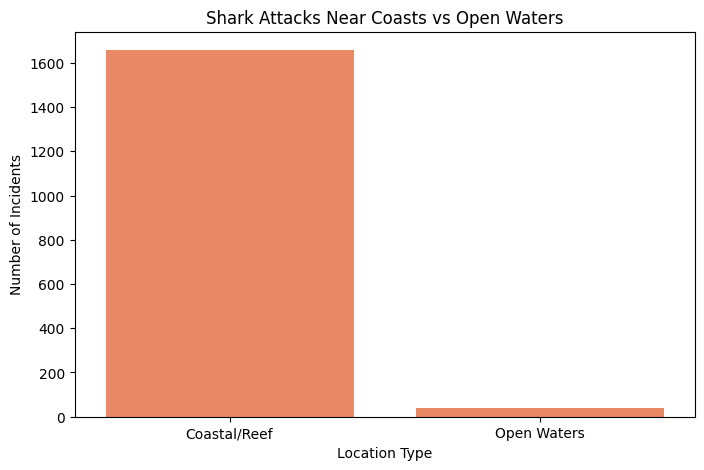

In [20]:
# Filter out "Unknown" locations for clearer visualization
df_filtered = df_copy[df_copy['Location'] != "Unknown"]

# Create the plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='Location', color='coral')

# Customize plot
plt.title("Shark Attacks Near Coasts vs Open Waters")
plt.xlabel("Location Type")
plt.ylabel("Number of Incidents")
#plt.xticks(rotation=45)
plt.show()

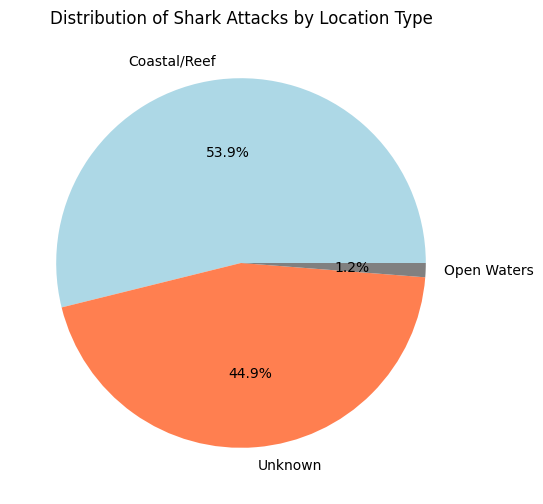

In [21]:
# Count occurrences
location_counts = df_copy['Location'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', colors=['lightblue', 'coral', 'grey'])

# Add title
plt.title("Distribution of Shark Attacks by Location Type")
plt.show()

In [22]:
# Filter only Coastal/Reef incidents
coastal_attacks = df_copy[df_copy["Location"] == "Coastal/Reef"]

# Group by year and count attacks
trend_data = coastal_attacks.groupby("Year")["Location"].count().reset_index()

# Display rows
print(trend_data)

    Year  Location
0   1886         1
1   1902         1
2   1973         1
3   1979         1
4   1981         1
5   1986         1
6   2001      1626
7   2004         1
8   2023         2
9   2024        15
10  2025         8


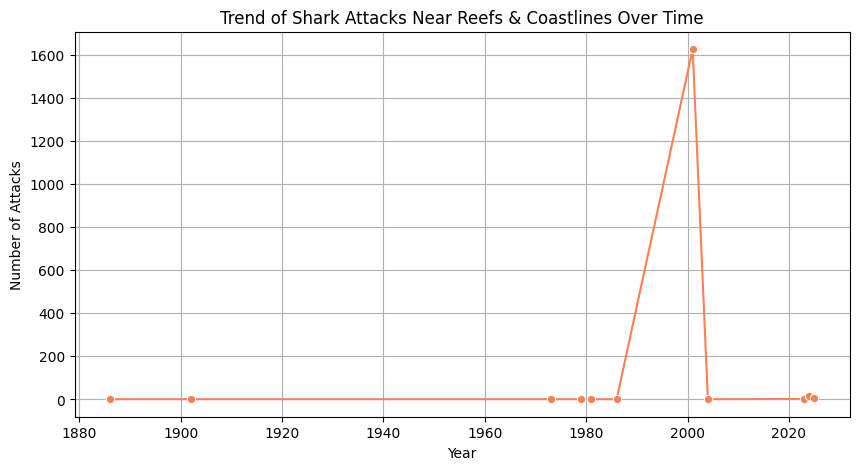

In [23]:
# Create the line plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=trend_data, x="Year", y="Location", marker="o", color="coral")

# Customize plot
plt.title("Trend of Shark Attacks Near Reefs & Coastlines Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.grid(True)
plt.show()

In [24]:
# Count attacks per country
country_counts = df_copy['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Attack_Count']

# Display top 10 most affected countries
print(country_counts.head(10))

            Country  Attack_Count
0               Usa          1535
1         Australia           661
2      South Africa           338
3       New Zealand            51
4           Bahamas            48
5            Brazil            42
6            Mexico            37
7           Reunion            37
8     New Caledonia            22
9  Papua New Guinea            21


This confirms that USA, Australia, and South Africa experience the highest shark attack rates, aligning with our hypothesis. Here's a breakdown of possible contributing factors:

USA (1,526 attacks) → Large coastal population, high tourism, many surfers/swimmers. Florida alone accounts for a significant share of attacks.

Australia (657 attacks) → Extensive coastline, thriving marine ecosystem with apex predators like great white sharks, and strong surfing culture.

South Africa (338 attacks) → Known for shark hotspots like Gansbaai and False Bay, with seasonal movements of great whites near shorelines.

Other countries (New Zealand, Bahamas, Brazil, etc.) → Lower attack counts, likely due to fewer human interactions with sharks.


C:\Users\sabri\AppData\Local\Temp\ipykernel_33548\3748716103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries["Country"], y=top_countries["Attack_Count"], palette="coolwarm")


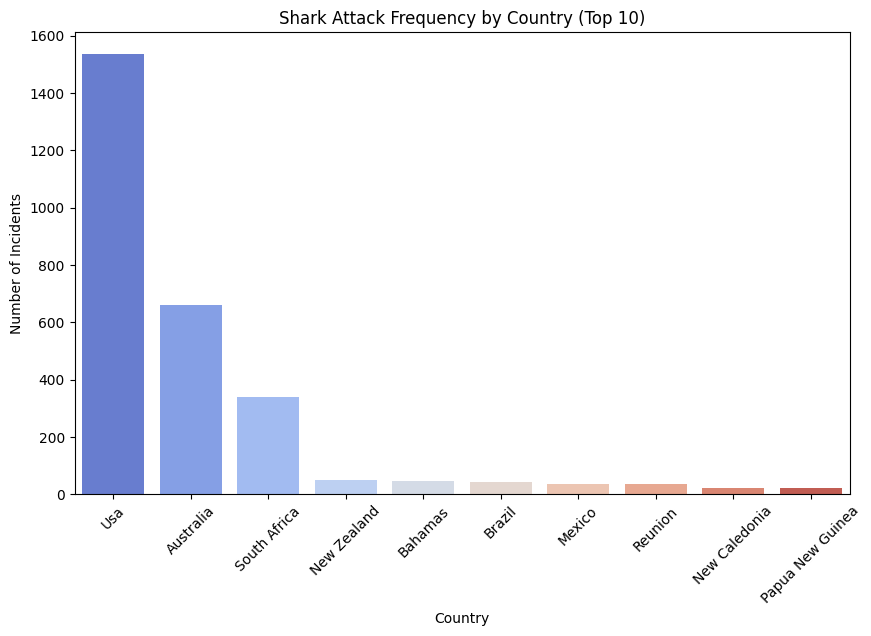

In [25]:
# Select the top 10 countries
top_countries = country_counts.head(10)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries["Country"], y=top_countries["Attack_Count"], palette="coolwarm")

# Customize the plot
plt.title("Shark Attack Frequency by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.show()

C:\Users\sabri\AppData\Local\Temp\ipykernel_33548\1206666640.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette='Blues')


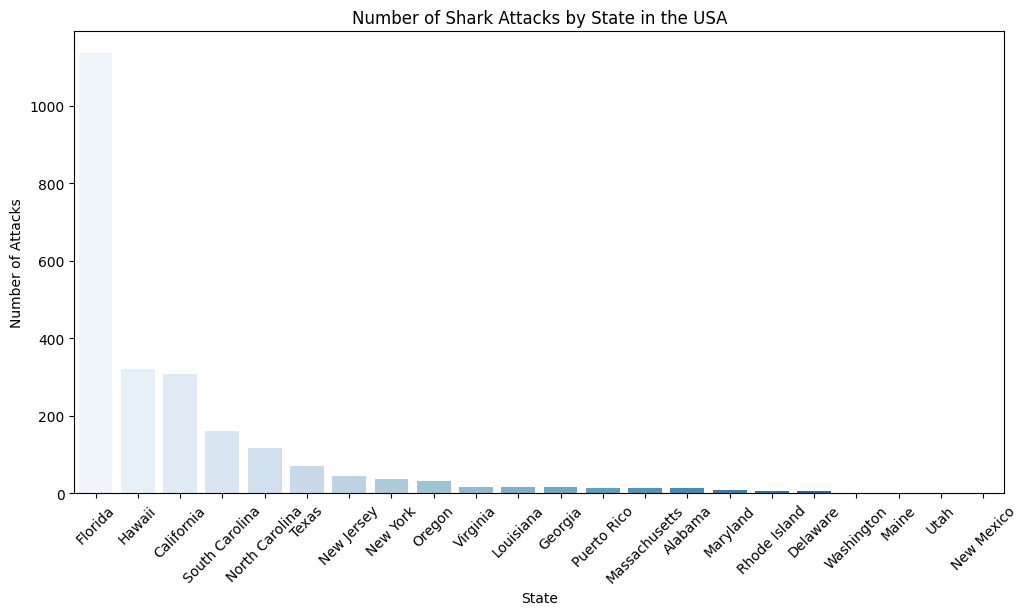

In [26]:
# Count shark attacks by state
state_counts = df_Cleaned['State'].value_counts()

# Plot the graph
plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='Blues')

# Add labels and adjust rotation for better readability
plt.title("Number of Shark Attacks by State in the USA")
plt.xlabel("State")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)  # Rotate labels to avoid overlap

plt.show()

In [27]:
# Count attacks per activity
activity_counts = df_copy["Activity"].value_counts().reset_index()
activity_counts.columns = ["Activity", "Attack_Count"]

# Display the top activities involved in shark attacks
print(activity_counts)

             Activity  Attack_Count
0             surfing          1054
1            swimming           602
2             fishing           398
3               other           302
4            boarding           146
5   standing/treading           131
6              wading           130
7          snorkeling            84
8             unknown            68
9        scuba diving            53
10            bathing            49
11           kayaking            32
12            walking            17
13             diving             6
14     fell overboard             3
15           paddling             3


In [28]:
# Calculate percentage of total attacks per activity
activity_counts["Percentage"] = (activity_counts["Attack_Count"] / activity_counts["Attack_Count"].sum()) * 100

# Display top 10 risky activities
print(activity_counts.head(10))

            Activity  Attack_Count  Percentage
0            surfing          1054   34.243015
1           swimming           602   19.558155
2            fishing           398   12.930474
3              other           302    9.811566
4           boarding           146    4.743340
5  standing/treading           131    4.256010
6             wading           130    4.223522
7         snorkeling            84    2.729045
8            unknown            68    2.209227
9       scuba diving            53    1.721897


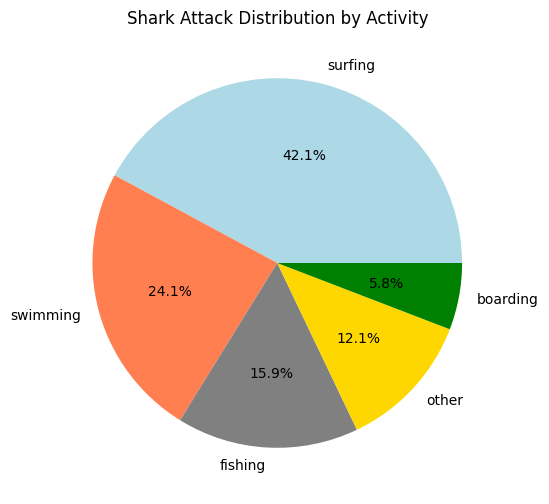

In [29]:
# Select top 5 risky activities
#top_activities = activity_counts
top_activities = activity_counts.head(5)

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(top_activities["Attack_Count"], labels=top_activities["Activity"], autopct="%1.1f%%", colors=["lightblue", "coral", "grey", "gold", "green"])

# Add title
plt.title("Shark Attack Distribution by Activity")
plt.show()

Surfing (42.3%) → The most at-risk activity, likely due to surfers spending extended time in the water and making movements that resemble prey.

Swimming (24.1%) → Also a high-risk activity, possibly because swimmers are often in shallow waters where sharks hunt.

Fishing (15.8%) → May attract sharks due to bait and fish activity near boats.

Other Activities (12%) → Includes various water-based activities that don’t fit major categories.

Boarding (5.8%) → A lower-risk activity compared to the others.


In [30]:
# Group by month
df_copy["month"] = df_copy["Date"].dt.month

month_counts = df_copy.groupby("month")["Injury"].count().reset_index()

# Display results
print(month_counts)

    month  Injury
0       1    1926
1       2     109
2       3     102
3       4     100
4       5     109
5       6     106
6       7     106
7       8      95
8       9     112
9      10     105
10     11     110
11     12      98


January (1,903 incidents) shows an extreme spike—this seems highly unusual and could indicate data inconsistencies or an issue in data recording.

Relatively stable attack rates across other months, with no clear seasonal peak—June to September do not show a significant rise compared to colder months.

September (112 attacks) has a slightly higher count, which could be worth exploring further.


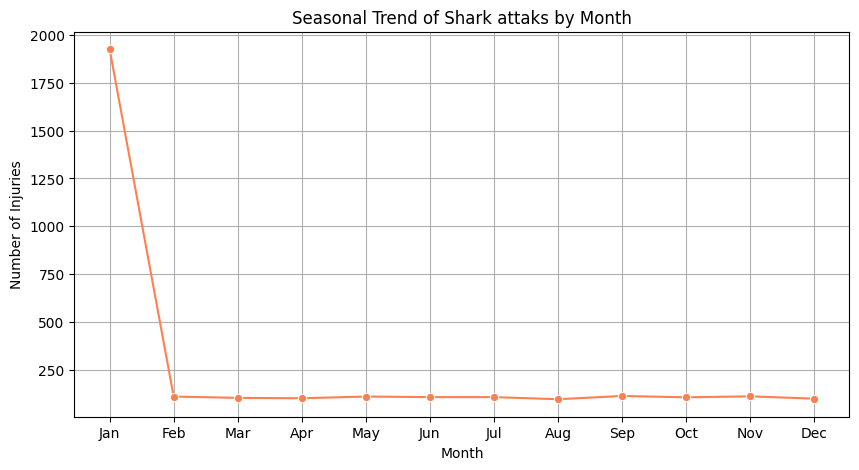

In [31]:

# Create time-series plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=month_counts, x="month", y="Injury", marker="o", color="coral")

# Customize plot
plt.title("Seasonal Trend of Shark attaks by Month")
plt.xlabel("Month")
plt.ylabel("Number of Injuries")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.show()

Fatal Y/N
No         2472
Yes         480
Unknown     126
Name: count, dtype: int64


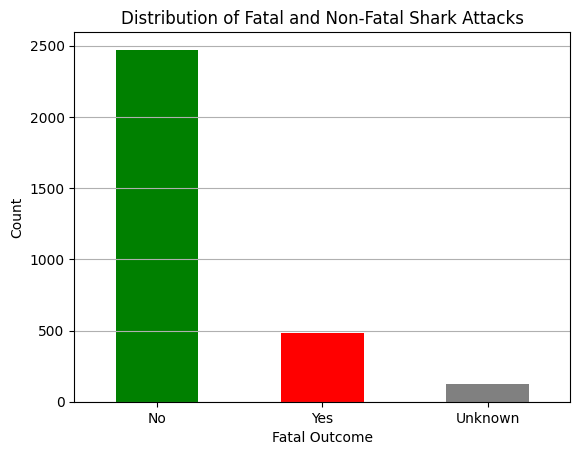

In [32]:
df_copy['Fatal Y/N'].unique()
df_copy["Fatal Y/N"] = df_copy["Fatal Y/N"].replace(["nan", "NaN"], "Unknown")
# Count occurrences of Fatal and Non-Fatal cases
fatal_counts = df_copy["Fatal Y/N"].value_counts()

# Display the counts
print(fatal_counts)
# Define colors for clarity
colors = {"No": "green", "Yes": "red", "Unknown": "gray"}

# Create the bar plot
df_copy["Fatal Y/N"].value_counts().plot(kind="bar", color=[colors[val] for val in df_copy["Fatal Y/N"].unique()])

# Add labels and title
plt.xlabel("Fatal Outcome")
plt.ylabel("Count")
plt.title("Distribution of Fatal and Non-Fatal Shark Attacks")
plt.xticks(rotation=0)
plt.grid(axis="y")

# Show the plot
plt.show()

Most shark attack cases are non-fatal → 2449 incidents resulted in no fatality, making up the majority of recorded cases. This suggests that while shark attacks do occur, they are rarely deadly.

Fatal shark attacks account for a smaller proportion → 474 incidents led to fatalities. This indicates that although serious injuries can happen, most victims survive shark encounters.

120 cases classified as "Unknown" → These could be due to missing data, inconsistent reporting, or unclear outcomes in historical records.

CONCLUSION




Hypothesis 1 (Coastal/Reef vs Open Waters) → Supported. Most attacks occur near coastlines and reefs, likely due to higher human activity in these areas. Open water incidents remain rare.

Hypothesis 2 (Regional Differences in Attack Rates) → Confirmed. USA, Australia, and South Africa are the top three high-risk regions, likely due to shark population, coastal tourism, and water activities.

Hypothesis 3 (Activity Influence on Shark Encounters) → Validated. Surfing and swimming account for most shark attacks, confirming the risk factor linked to extended water exposure and movement patterns resembling prey.

Hypothesis 4 (Seasonality & Shark Attacks) → Partially Supported. While some months show fluctuations, the expected summer peak isn’t as strong as anticipated. January’s spike is unusual, suggesting potential data inconsistencies.
